# Raw MED_SAM inference

In [1]:
import sys, os
dir1 = os.path.abspath(os.path.join(os.path.abspath(''), '..', '..'))
if not dir1 in sys.path: sys.path.append(dir1)
dir2 = os.path.abspath(os.path.join(os.path.abspath(''), '..', '2_no_finetuning'))
if not dir2 in sys.path: sys.path.append(dir2)

from utils.environment import setup_data_vars
from MEDSAM_helper_functions import *

setup_data_vars()

In [2]:
import torch
import random
import numpy as np

seed = 42

torch.cuda.empty_cache()
os.environ['PYTHONHASHSEED']=str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
import argparse
import sys

parser = argparse.ArgumentParser(description="Preprocess CT/MR images")
parser.add_argument('anatomy', type=str, help='anatomy of the images')
parser.add_argument('model_type', type=str, help='type of model the data was finetuned on')

original_args = sys.argv
sys.argv = [original_args[0], 'CTVn', 'point']

args = parser.parse_args()

In [4]:
pre_processed_imgs = os.path.join(os.environ.get('MedSAM_preprocessed'), 'imgs')
pre_processed_gts = os.path.join(os.environ.get('MedSAM_preprocessed'), 'gts', args.anatomy)
pre_processed_imgs, pre_processed_gts

('/vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/data/MedSAM_preprocessed/imgs',
 '/vol/biomedic3/bglocker/ugproj2324/az620/radiotherapy/data/MedSAM_preprocessed/gts/CTVn')

## Set up model

In [5]:
import torch.nn as nn

class MedSAM(nn.Module):
    def __init__(self, 
                image_encoder, 
                mask_decoder,
                prompt_encoder,
                freeze_image_encoder=False,
                ):
        super().__init__()
        self.image_encoder = image_encoder
        self.mask_decoder = mask_decoder
        self.prompt_encoder = prompt_encoder

        # freeze prompt encoder
        for param in self.prompt_encoder.parameters():
            param.requires_grad = False
        
        self.freeze_image_encoder = freeze_image_encoder
        if self.freeze_image_encoder:
            for param in self.image_encoder.parameters():
                param.requires_grad = False

    def forward(self, image, point_prompt):

        # do not compute gradients for pretrained img encoder and prompt encoder
        with torch.no_grad():
            image_embedding = self.image_encoder(image) # (B, 256, 64, 64)
            # not need to convert box to 1024x1024 grid
            # bbox is already in 1024x1024
            sparse_embeddings, dense_embeddings = self.prompt_encoder(
                points=point_prompt,
                boxes=None,
                masks=None,
            )
        low_res_masks, iou_predictions = self.mask_decoder(
            image_embeddings=image_embedding, # (B, 256, 64, 64)
            image_pe=self.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
          ) # (B, 1, 256, 256)

        return low_res_masks

In [6]:
import torch
import numpy as np
MedSAM_CKPT_PATH = os.path.join(os.environ.get('PROJECT_DIR'),  "models/MedSAM/work_dir/MedSAM/medsam_vit_b.pth")
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
og_medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)

MedSAM_FINETUNE_PATH = os.path.join(os.environ.get('MedSAM_finetuned'), args.model_type, args.anatomy, 'checkpoint_best.pth')
device = "cuda:0"
checkpoint = torch.load(MedSAM_FINETUNE_PATH)
medsam_model.load_state_dict(checkpoint['model'])

medsam_model = MedSAM(
    image_encoder = medsam_model.image_encoder,
    mask_decoder = medsam_model.mask_decoder,
    prompt_encoder = medsam_model.prompt_encoder,
    freeze_image_encoder = True
)

og_medsam_model = MedSAM(
    image_encoder = og_medsam_model.image_encoder,
    mask_decoder = og_medsam_model.mask_decoder,
    prompt_encoder = og_medsam_model.prompt_encoder,
    freeze_image_encoder = True
)

medsam_model = medsam_model.to(device)
og_medsam_model = og_medsam_model.to(device)
medsam_model.eval()
og_medsam_model.eval()

"model set to evaluation mode"

'model set to evaluation mode'

## Inference

In [7]:
# As copied from 1_train_point_prompt.ipynb

from torch.utils.data import Dataset, DataLoader
import cv2
import random
import re

image_id_from_file_name_regex = r'.*_(\d+).*'
slice_id_from_file_name_regex = r'.*-(\d+).*'

class SAM_Dataset(Dataset):
    """A torch dataset for delivering slices of any axis to a medsam model."""

    def __init__(self, img_path, gt_path, id_split, data_aug=False):
        """
        Args:
            img_path (string): Path to the directory containing the images
            gt_path (string): Path to the directory containing the ground truth masks
            id_split (list): List of image ids to include in the dataset
        """

        self.root_img_path = img_path
        self.root_gt_path = gt_path
        self.id_split = id_split
        self.data_aug = data_aug
        
        # Assume that axese 0 1 and 2 have been processed.
        filter_fn = lambda x : x.endswith('.npy') and int(re.search(image_id_from_file_name_regex, x).group(1)) in id_split
        self.axis0_imgs = list(filter(filter_fn, os.listdir(os.path.join(gt_path, 'axis0'))))
        self.axis1_imgs = list(filter(filter_fn, os.listdir(os.path.join(gt_path, 'axis1'))))
        self.axis2_imgs = list(filter(filter_fn, os.listdir(os.path.join(gt_path, 'axis2'))))

    def __len__(self):
        return len(self.axis0_imgs) + len(self.axis1_imgs) + len(self.axis2_imgs)

    def __getitem__(self, idx):
        assert 0 <= idx < self.__len__(), f"Index {idx} is out of range for dataset of size {self.__len__()}"

        # Fetch the image and ground truth mask. For safety, we index the items around the
        # ground truth masks, so that if for some reason the images are misaligned we will
        # guarantee that we will fetch the correct image

        if idx < len(self.axis0_imgs):
            axis, gt_name = 0, self.axis0_imgs[idx]
        elif idx < len(self.axis0_imgs) + len(self.axis1_imgs):
            axis, gt_name = 1, self.axis1_imgs[idx - len(self.axis0_imgs)]
        else:
            axis, gt_name = 2, self.axis2_imgs[idx - len(self.axis0_imgs) - len(self.axis1_imgs)]

        image_id = int(re.search(image_id_from_file_name_regex, gt_name).group(1))
        slice_id = int(re.search(slice_id_from_file_name_regex, gt_name).group(1))

        img_name = f'CT_zzAMLART_{image_id:03d}-{slice_id:03d}.npy'
        
        # Load the image and ground truth mask

        img_path = os.path.join(self.root_img_path, f'axis{axis}', img_name)
        gt_path = os.path.join(self.root_gt_path, f'axis{axis}', gt_name)

        img = np.load(img_path, 'r', allow_pickle=True) # (H, W, C)
        gt = np.load(gt_path, 'r', allow_pickle=True) # (H, W, C)

        # Pre-process where necessary

        img = np.transpose(img, (2, 0, 1)) # (C, H, W)
        assert np.max(img) <= 1. and np.min(img) >= 0., 'image should be normalized to [0, 1]'

        # add data augmentation: random fliplr and random flipud
        if self.data_aug:
            if random.random() > 0.5:
                img = np.ascontiguousarray(np.flip(img, axis=-1))
                gt = np.ascontiguousarray(np.flip(gt, axis=-1))
            if random.random() > 0.5:
                img = np.ascontiguousarray(np.flip(img, axis=-2))
                gt = np.ascontiguousarray(np.flip(gt, axis=-2))
        
        # Select a random point. We will use this point to guide the model to segment the
        # anatomy. The idea is that we want to select the center of this shape with
        # greater probability than the outside of the shape.
        gt = np.uint8(gt > 0)
        y_indices, x_indices = np.where(gt > 0)

        # Calculate the centroid of the segmentation
        centroid_x = np.mean(x_indices)
        centroid_y = np.mean(y_indices)

        # Calculate distances of each point from the centroid
        distances = np.sqrt((x_indices - centroid_x)**2 + (y_indices - centroid_y)**2)

        # Invert the distances to get higher probabilities for points closer to the
        # centroid
        inverse_distances = 1 / (distances + 1e-6)  # adding a small value to avoid division by zero

        # Normalize the probabilities
        probabilities = inverse_distances / np.sum(inverse_distances)

        # Sample a point based on the calculated probabilities
        index = np.random.choice(len(x_indices), p=probabilities)
        x_point = x_indices[index]
        y_point = y_indices[index]

        coords = np.array([x_point, y_point])

        # The output of the model is 256x256, and it is easier to reason about
        # constricting an image, rather than expanding the output back ot 1024x1024

        gt = cv2.resize(
            gt,
            (256, 256),
            interpolation=cv2.INTER_NEAREST
        )

        return {
            "image": torch.tensor(img).float(),
            "gt2D": torch.tensor(gt[None, :,:]).long(),
            "coords": torch.tensor(coords[None, ...]).float(),
            "image_name": img_name
        }

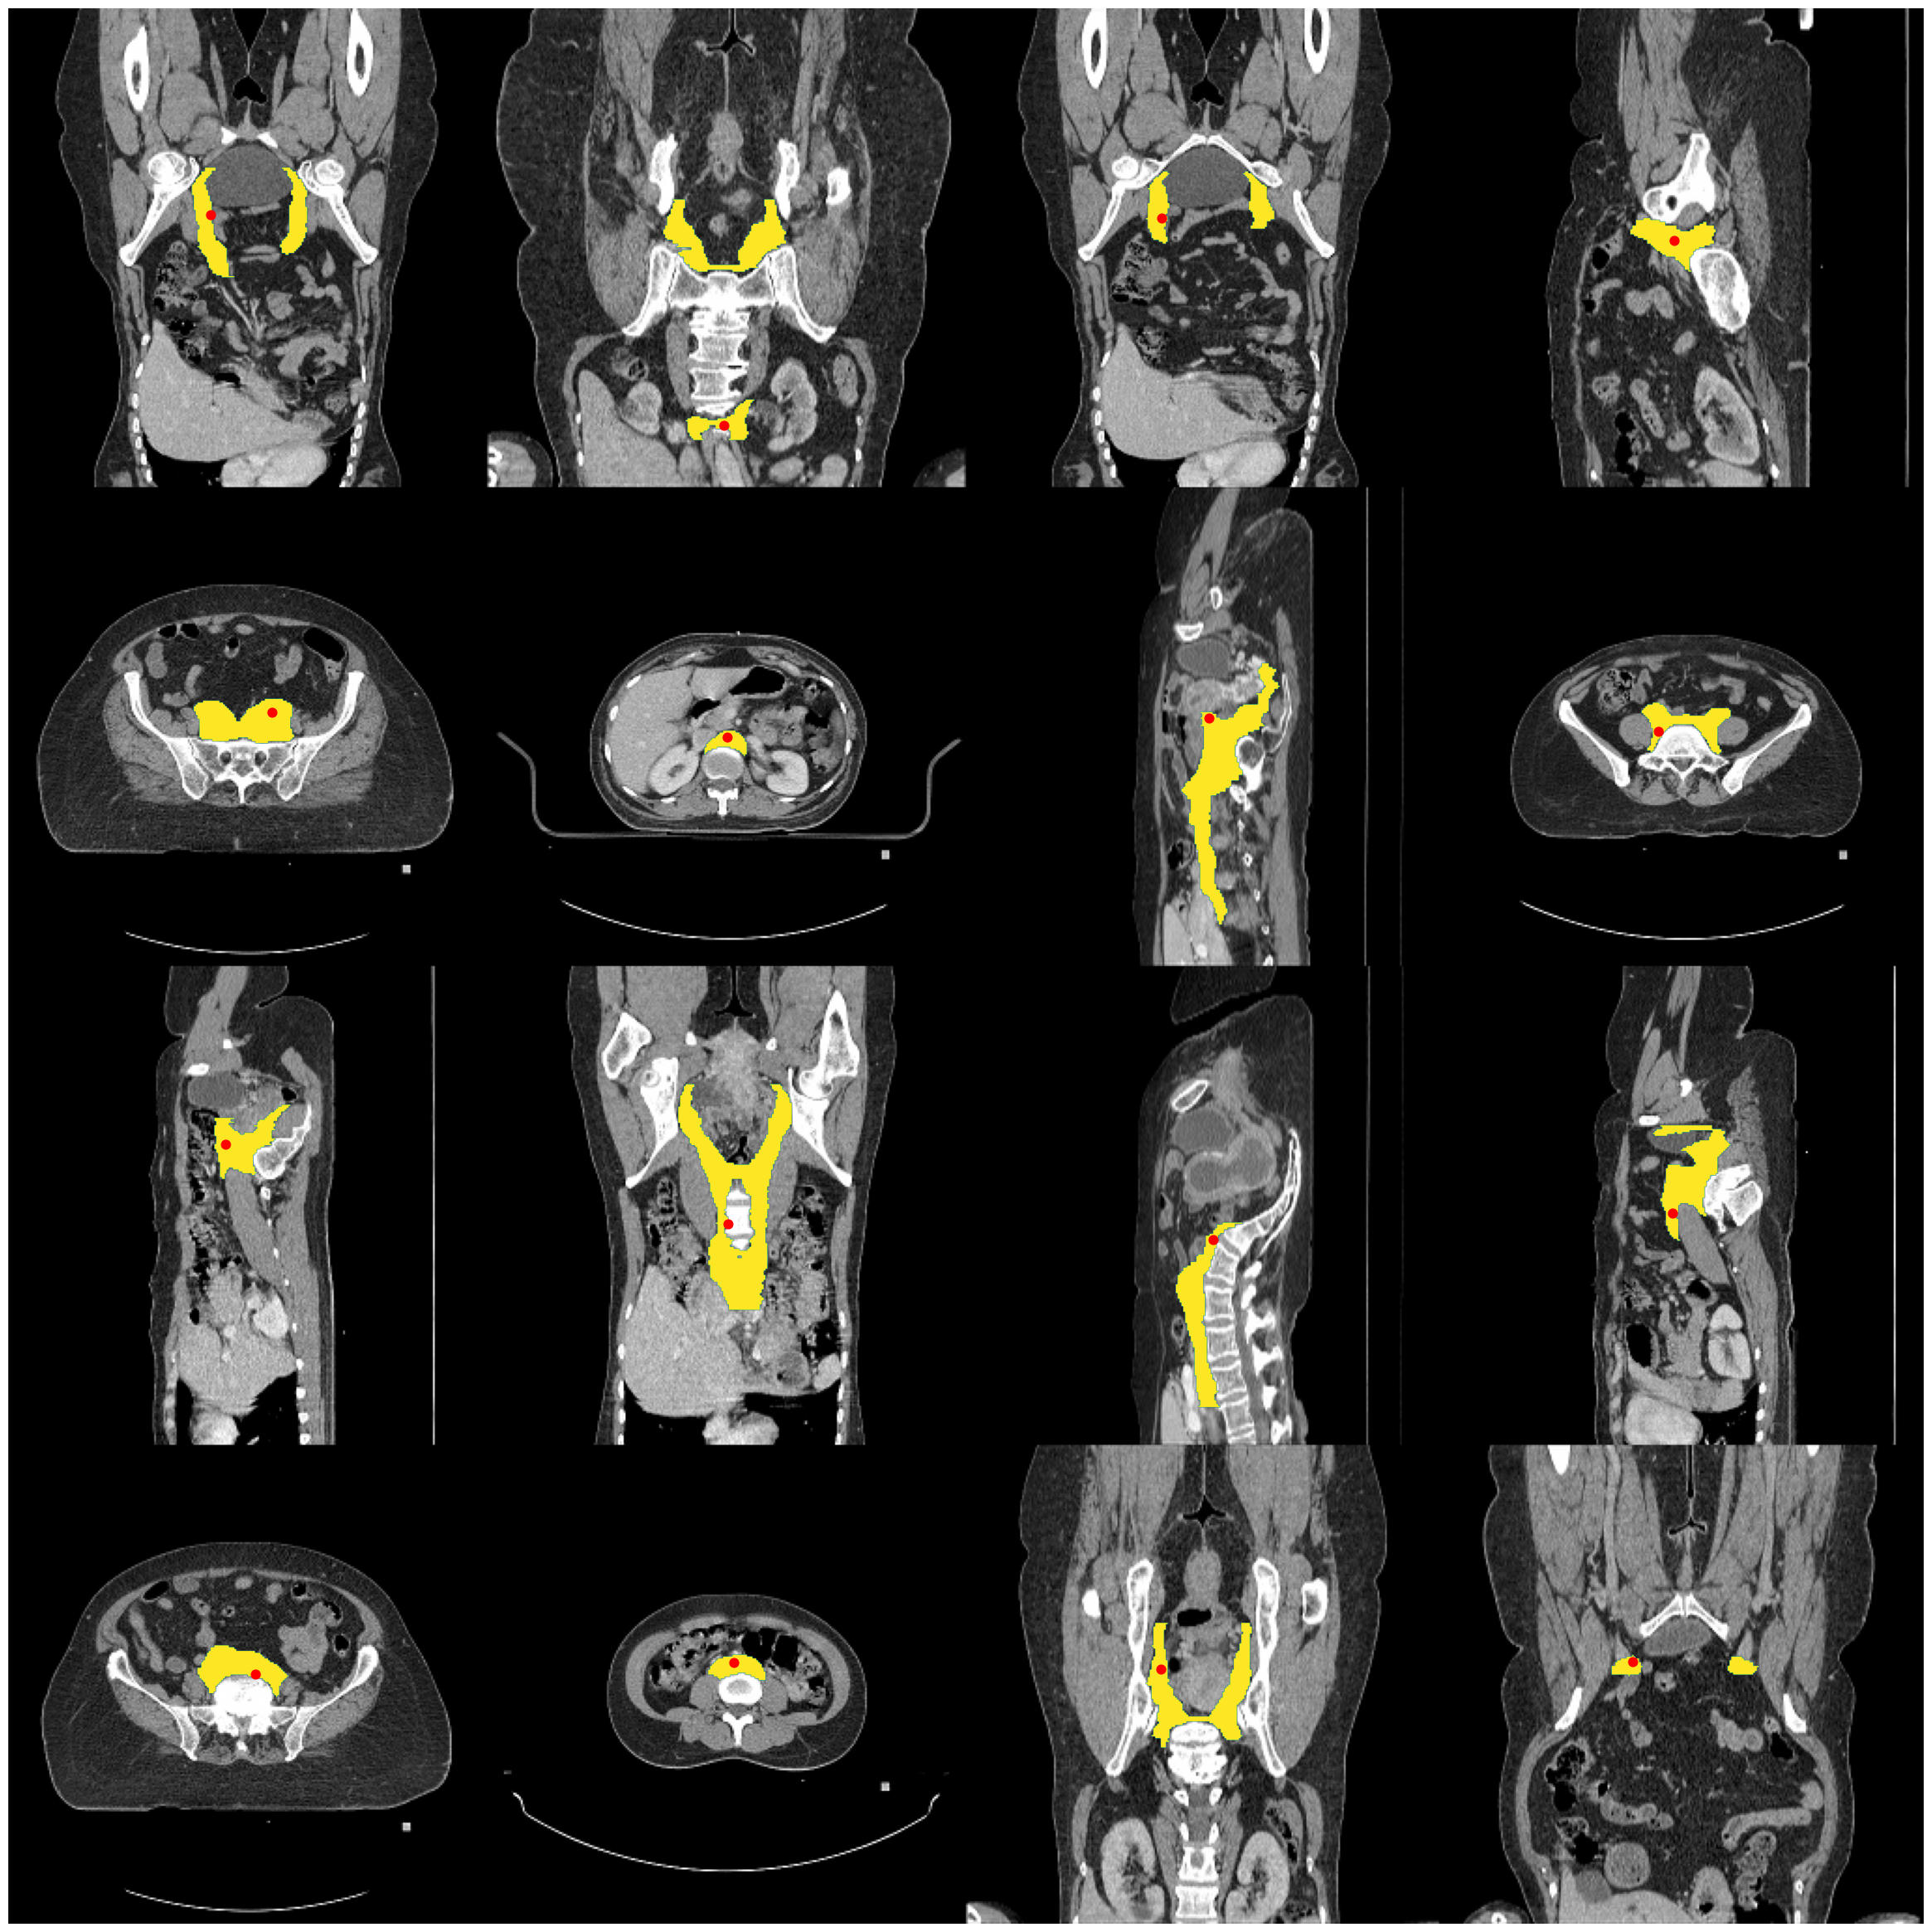

In [8]:
# quick test to see if the points are being generated correctly and transformations are also ok

import matplotlib.pyplot as plt

from torchvision.utils import make_grid
import torch.nn.functional as F

batch_size = 16

experimental_datset = SAM_Dataset(pre_processed_imgs, pre_processed_gts, [1,2,3,4,5], data_aug=False)
dataloader = torch.utils.data.DataLoader(experimental_datset, batch_size=batch_size, shuffle=True)

# Get a batch of examples
batch = next(iter(dataloader))

images = F.interpolate(batch['image'], size=(256, 256), mode='bilinear', align_corners=False)

grid_imgs = make_grid(images, nrow=4, padding=0)
grid_gts = make_grid(batch['gt2D'].float(), nrow=4, padding=0)
gts_mask = (grid_gts.sum(dim=0) > 0).float()

plt.figure(figsize=(30, 30))
plt.imshow(grid_imgs.permute(1, 2, 0))
plt.imshow(gts_mask, alpha=gts_mask, cmap='viridis')

shift_x = 0
shift_y = -256
for i in range(16):

    shift_y = shift_y + 256 if i % 4 == 0 else shift_y
    shift_x = shift_x + 256 if i % 4 != 0 else 0

    coord = batch['coords'][i].squeeze().numpy()
    x, y = coord[0], coord[1]
    x, y = x * 256 / 1024 + shift_x, y * 256 / 1024 + shift_y
    plt.scatter(x, y, c='r', s=60)

plt.axis('off')
plt.show()

In [9]:
# batch_size = 10

# dataset = SAM_Dataset( os.path.join(os.environ.get('MedSAM_preprocessed'), 'imgs') , os.path.join(os.environ.get('MedSAM_preprocessed'), 'gts', args.anatomy), [1,2,3,4,5,6])

# loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# for batch in loader:


image = batch['image']
gt2D = batch['gt2D']
coords_torch = batch['coords']
image_name = batch['image_name']

labels_torch = torch.ones(coords_torch.shape[0]).long() # (B,)
labels_torch = labels_torch.unsqueeze(1) # (B, 1)
image, gt2D = image.to(device), gt2D.to(device)
coords_torch, labels_torch = coords_torch.to(device), labels_torch.to(device)
point_prompt = (coords_torch, labels_torch)

medsam_lite_pred_og = og_medsam_model(image, point_prompt)
medsam_lite_pred_ft = medsam_model(image, point_prompt)

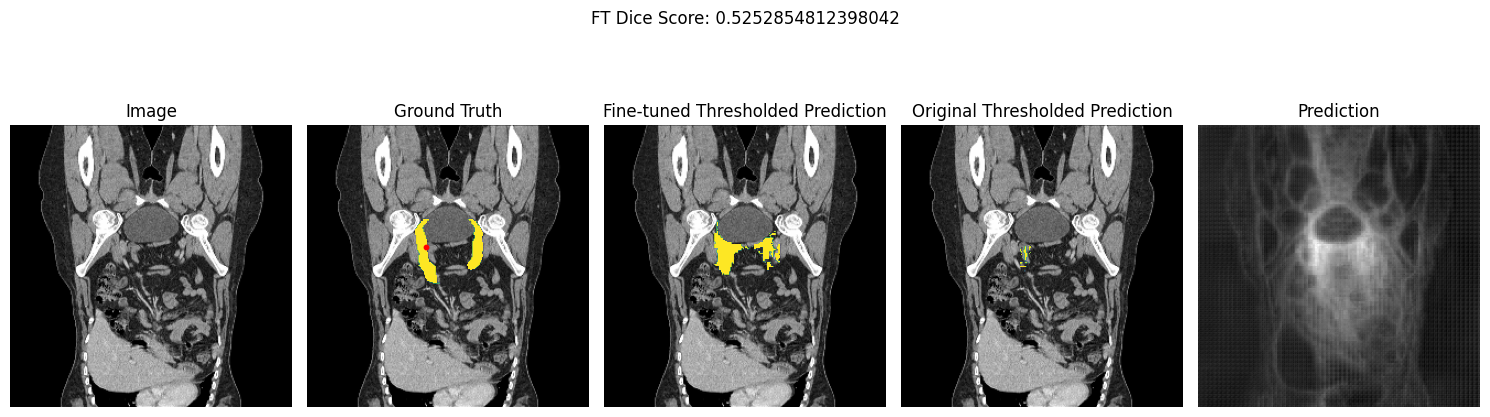

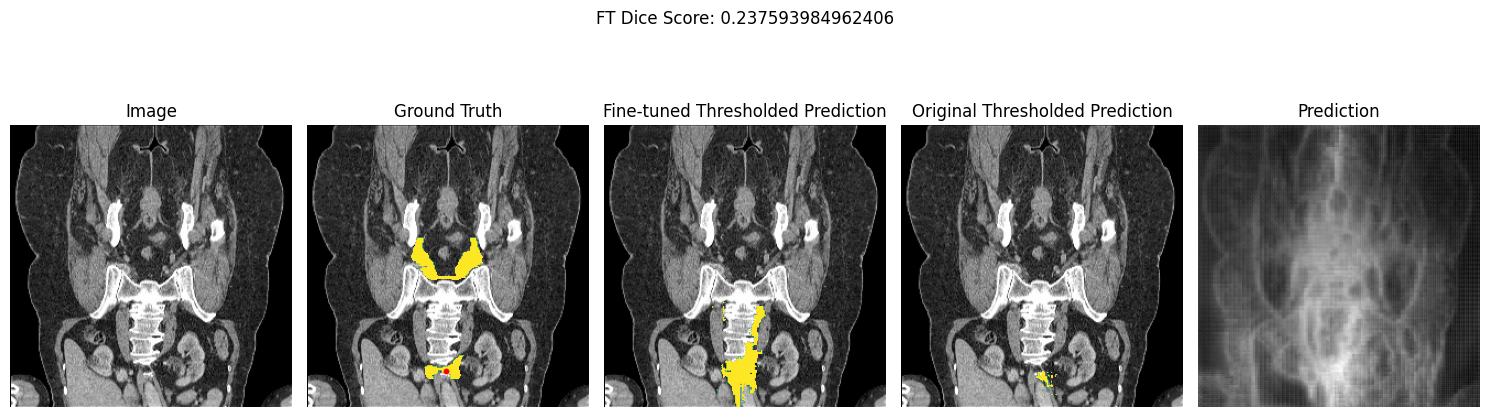

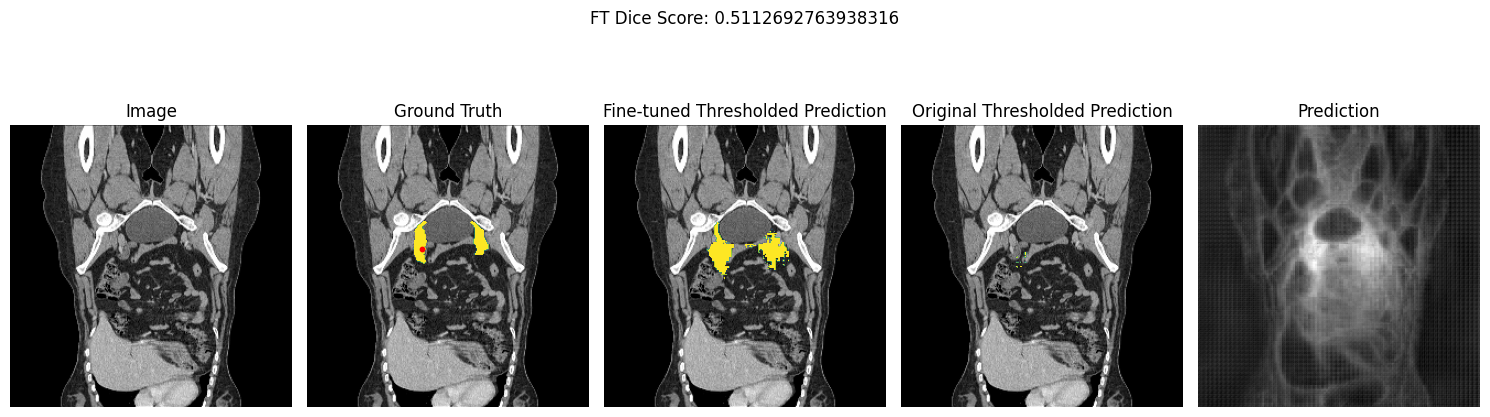

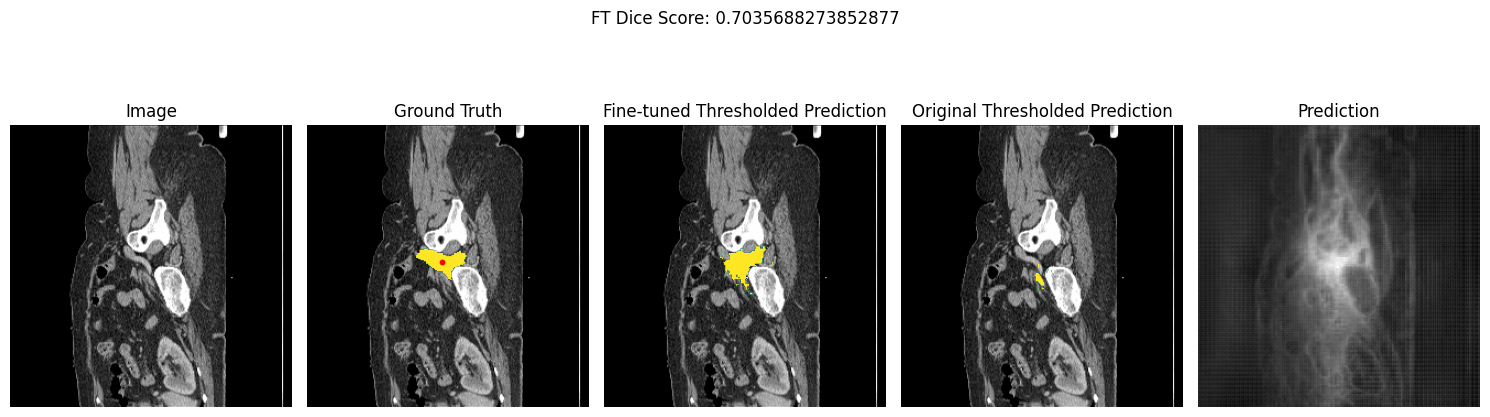

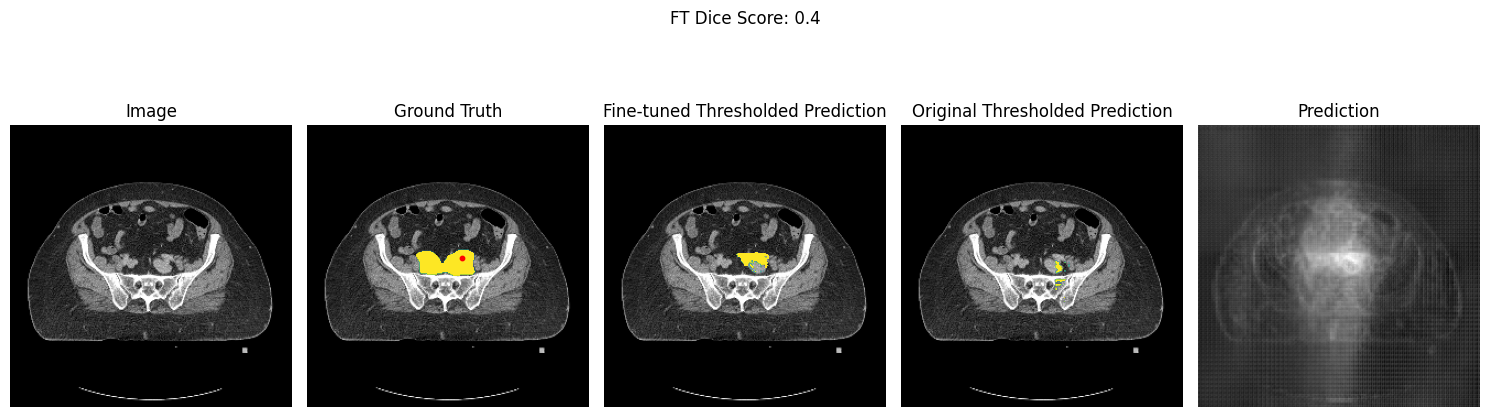

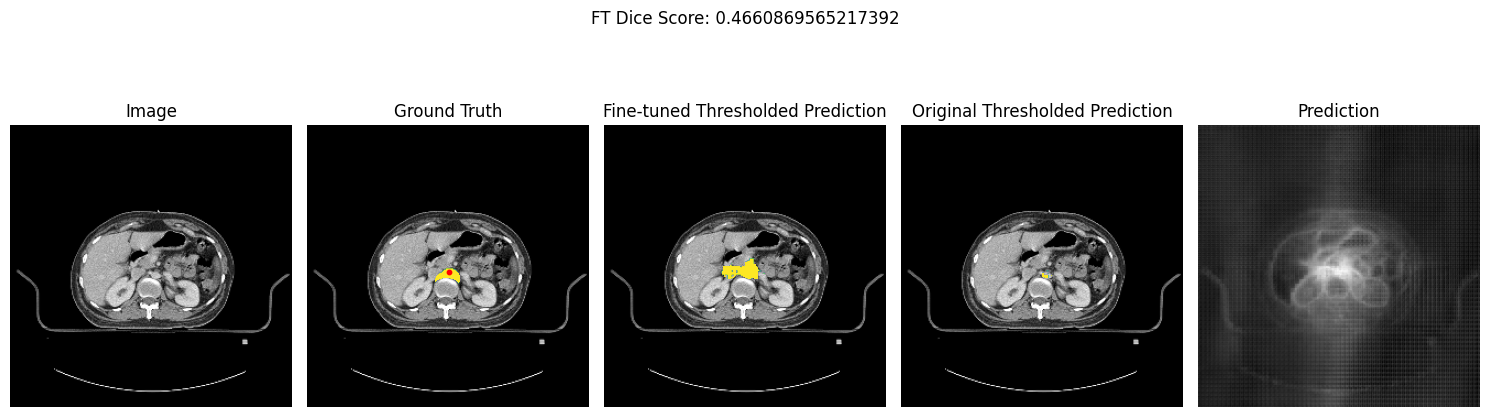

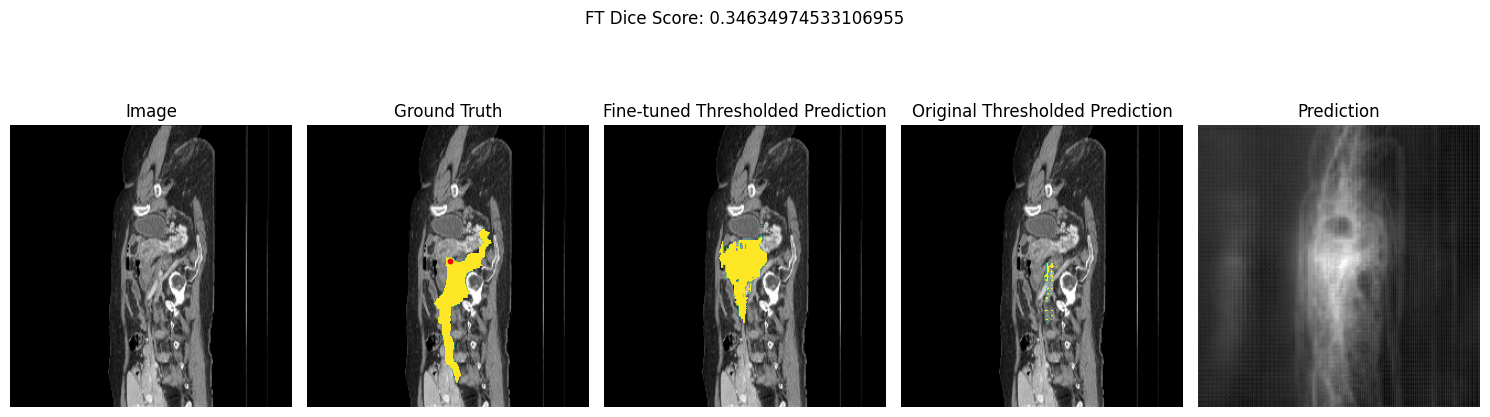

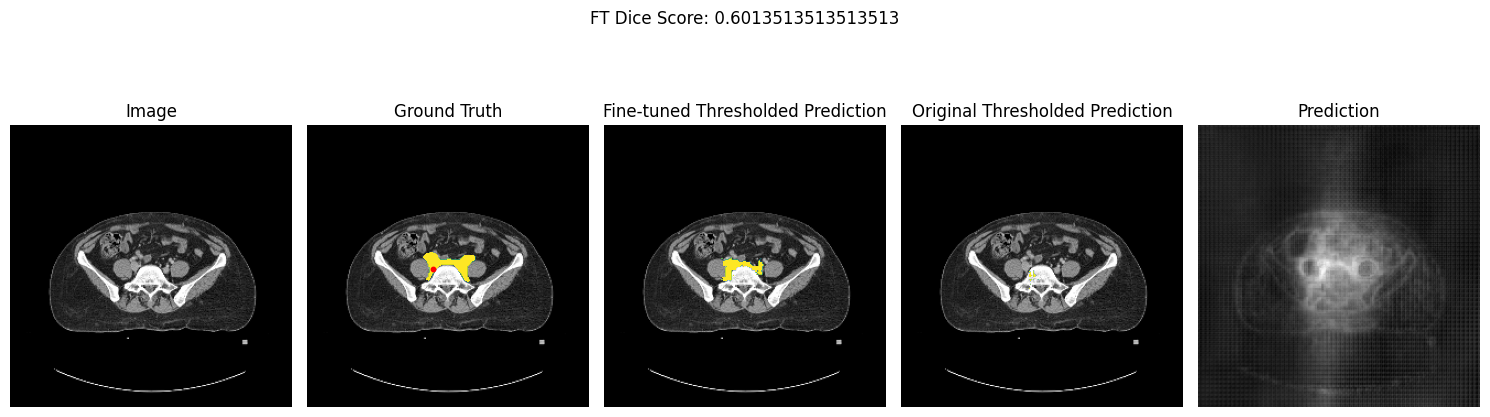

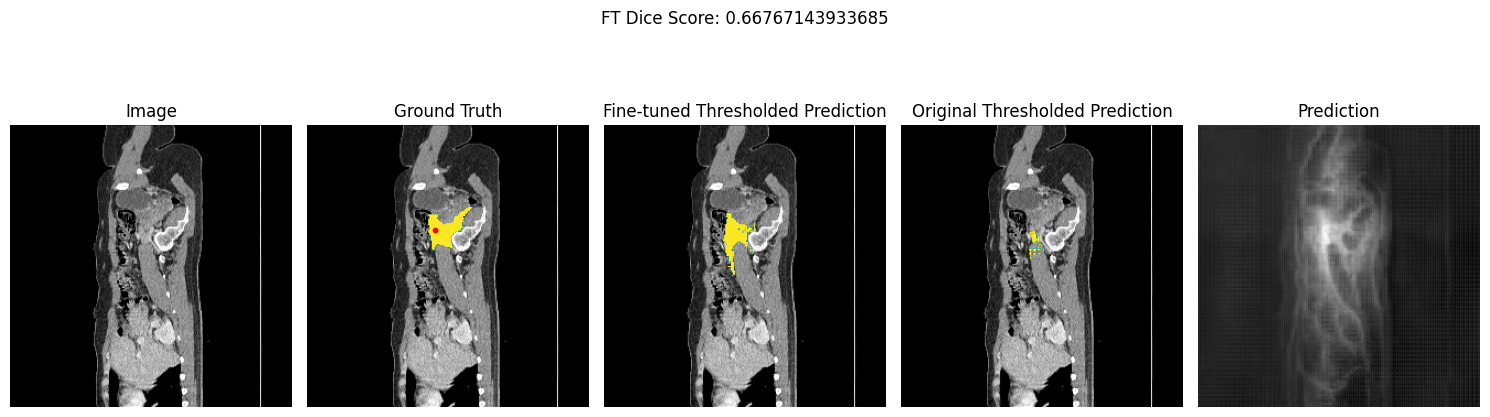

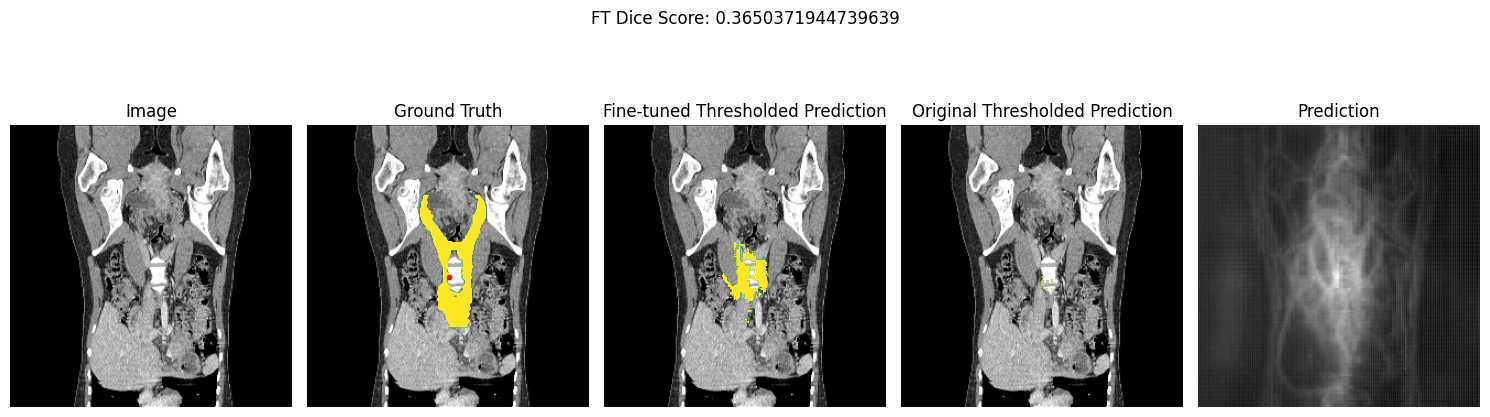

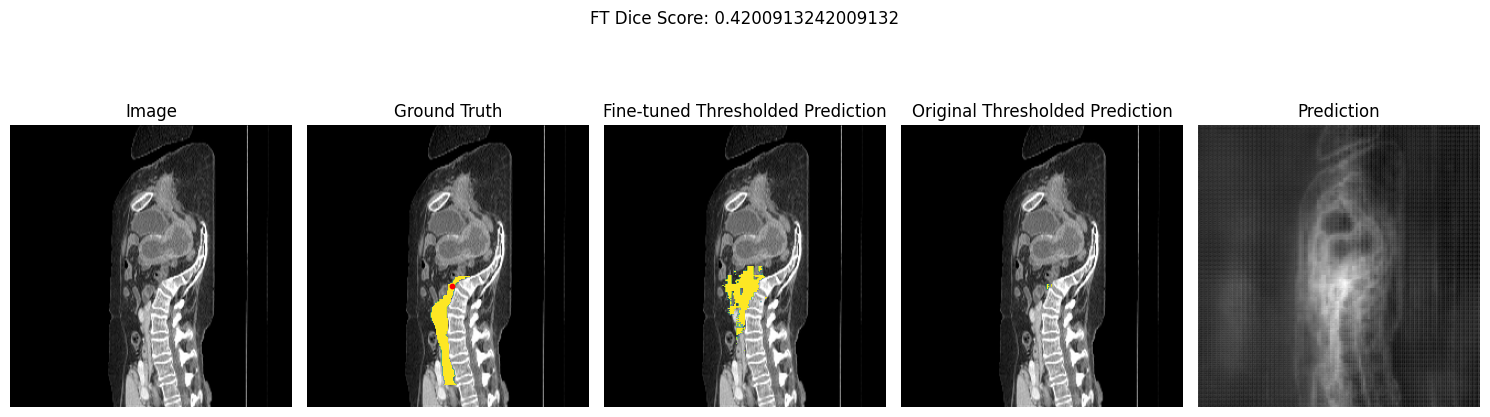

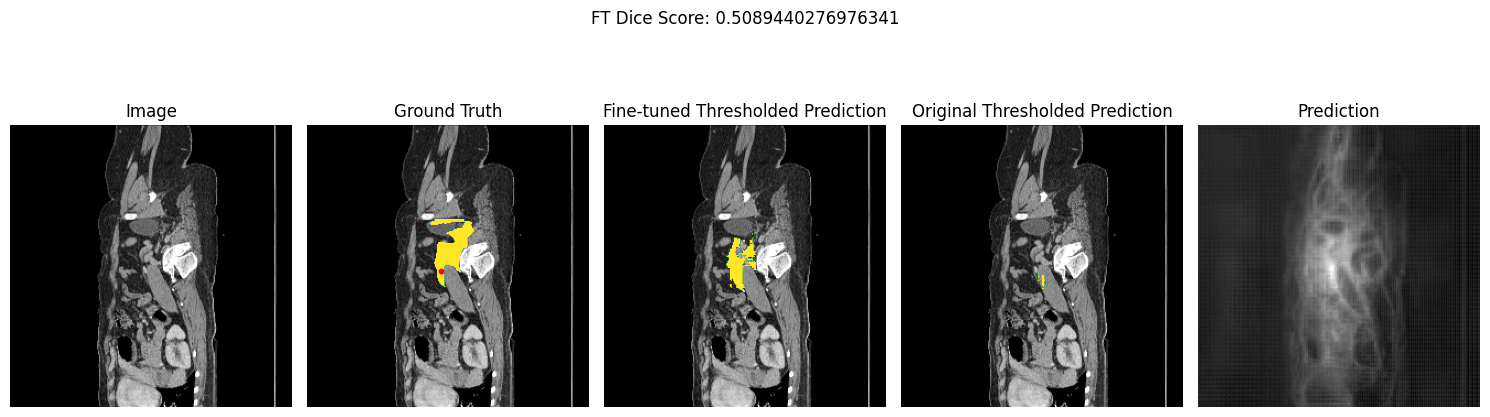

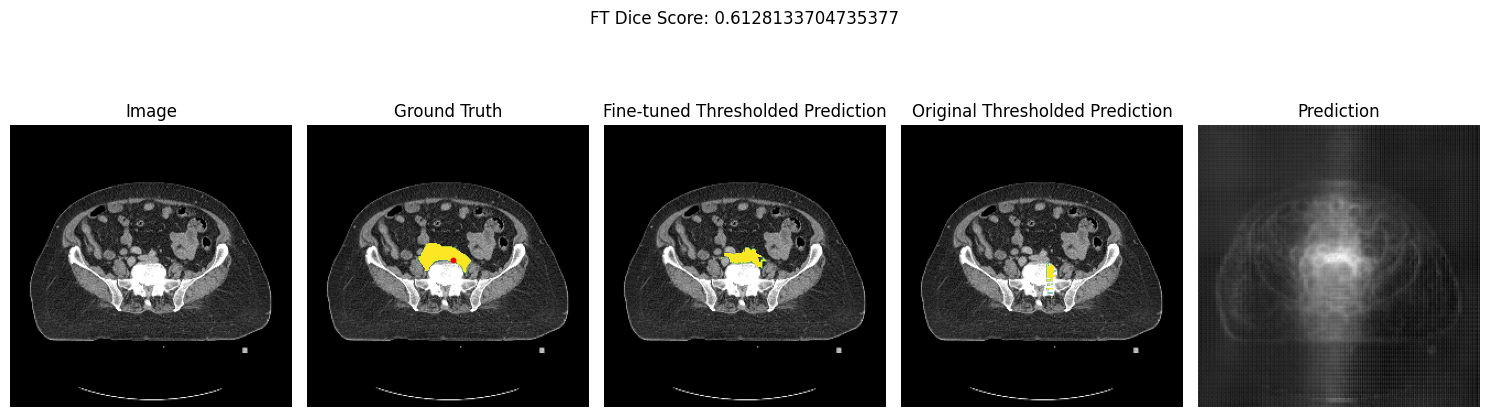

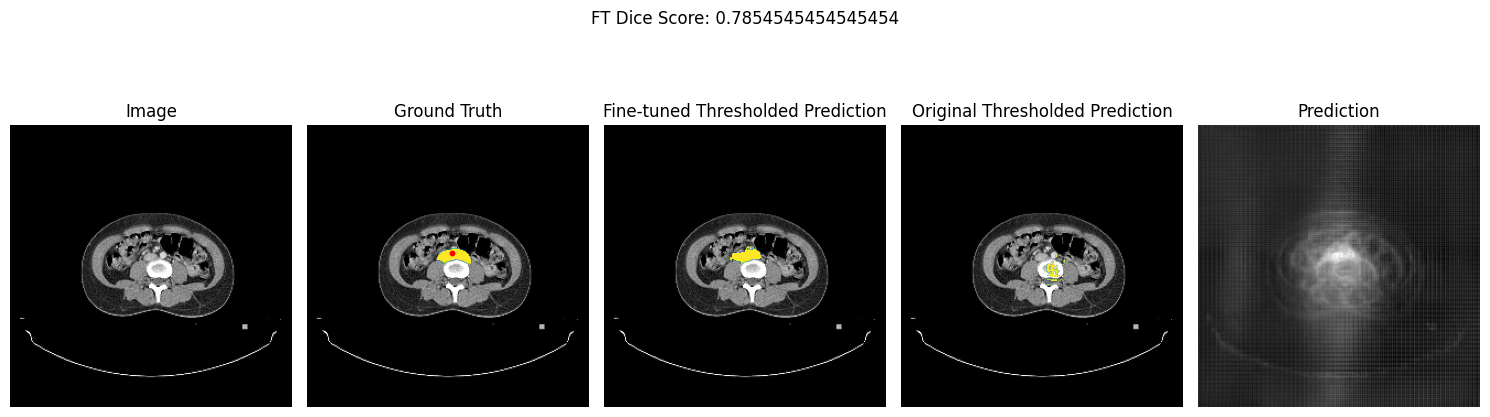

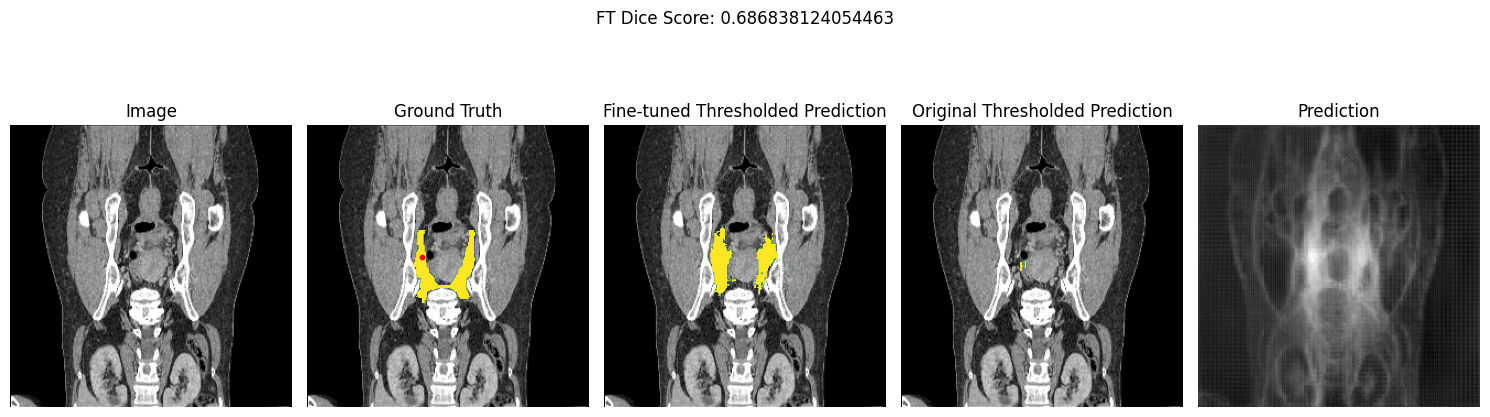

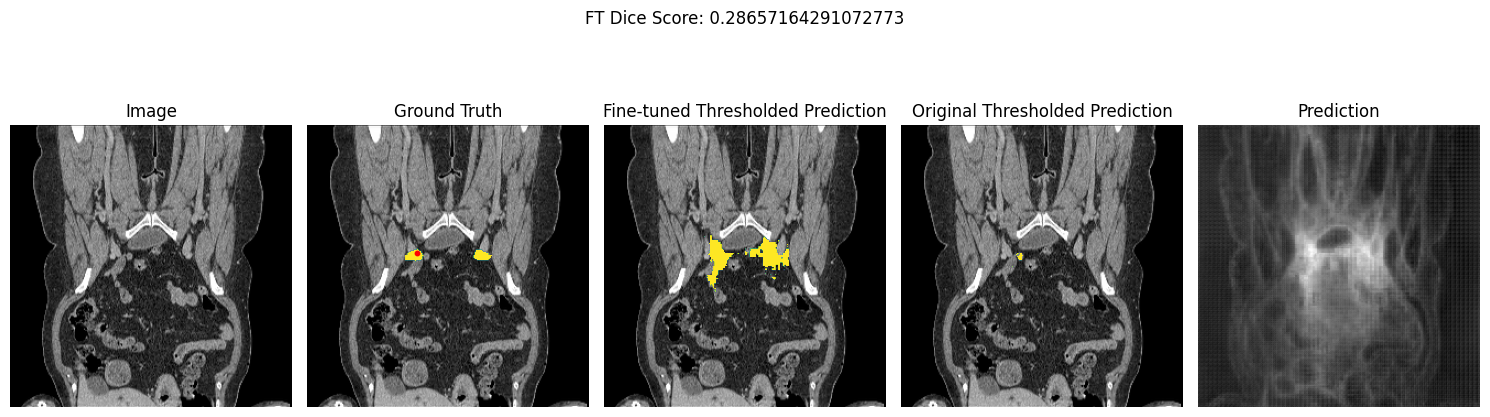

In [10]:
import matplotlib.pyplot as plt

import SimpleITK as sitk

# set up a dice score calculator from sitk

overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()

for i in range(batch_size):

    img = image[i].cpu().detach().numpy().transpose(1, 2, 0)
    gt = gt2D[i].cpu().detach().numpy()
    pred_logits_ft = medsam_lite_pred_ft[i]
    pred_logits_og = medsam_lite_pred_og[i]
    point = coords_torch[i].squeeze().cpu().detach().numpy()

    pred_ft = torch.sigmoid(pred_logits_ft).cpu().detach().numpy()  # (1, 1, 256, 256)
    pred_ft = (pred_ft > 0.5).astype(np.uint8)

    pred_og = torch.sigmoid(pred_logits_og).cpu().detach().numpy()
    pred_og = (pred_og > 0.5).astype(np.uint8)

    img = cv2.resize(
            img,
            (256, 256),
            interpolation=cv2.INTER_NEAREST
    )

    fig, axes = plt.subplots(1, 5, figsize=(15, 5))

    axes[0].imshow(img, cmap='gray')
    axes[0].set_title('Image')
    axes[0].axis('off')

    alpha_mask = np.where(gt[0] > 0, 1, 0).astype(np.float32)
    axes[1].imshow(img, cmap='gray')
    axes[1].imshow(gt[0], alpha=alpha_mask, cmap='viridis')
    axes[1].scatter(point[0] * 256 / 1024, point[1] * 256 / 1024, c='r', s=10)
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')

    alpha_mask = np.where(pred_ft[0] > 0, 1, 0).astype(np.float32)
    axes[2].imshow(img, cmap='gray')
    axes[2].imshow(pred_ft[0], alpha=alpha_mask, cmap='viridis')
    axes[2].set_title('Fine-tuned Thresholded Prediction')
    axes[2].axis('off')
    
    alpha_mask = np.where(pred_og[0] > 0, 1, 0).astype(np.float32)
    axes[3].imshow(img, cmap='gray')
    axes[3].imshow(pred_og[0], alpha=alpha_mask, cmap='viridis')
    axes[3].set_title('Original Thresholded Prediction')
    axes[3].axis('off')

    axes[4].imshow(img, cmap='gray')
    axes[4].imshow(pred_logits_ft[0].cpu().detach().numpy(), cmap='gray')
    axes[4].set_title('Prediction')
    axes[4].axis('off')

    overlap_measures_filter.Execute(sitk.GetImageFromArray(gt[0].astype(np.uint8)), sitk.GetImageFromArray(pred_ft[0].astype(np.uint8)))
    dice_score = overlap_measures_filter.GetDiceCoefficient()

    plt.suptitle(f'FT Dice Score: {dice_score}')
    plt.tight_layout()
    plt.show()